In [1]:
import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap

from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [16]:
def plot_1D(X):
    K, _, T = X.shape
    cmap = plt.cm.viridis  
    fig, ax = plt.subplots() 

    for k in range(K):
        for t in range(T - 1):
            ax.plot([t, t + 1], [X[k, 0, t], X[k, 0, t + 1]], color=cmap(t / (T - 1)))

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:

K = 100
T = 50
split = 20

def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(K, 2))

t_span = (0, 10)   
t_eval = np.linspace(t_span[0], t_span[1], T)  
X = np.zeros((K, 2, T))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)

6.0083557e-06
-3.3761132e-06


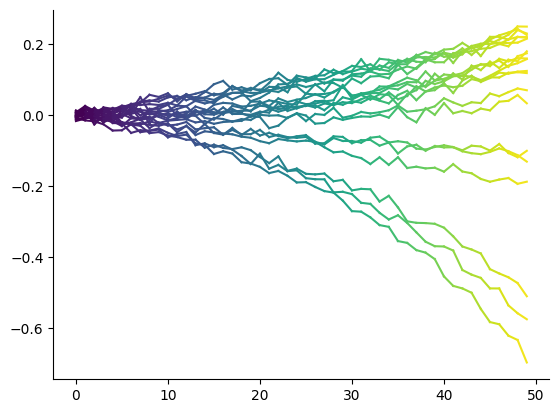

In [20]:
seed = 41
key = random.PRNGKey(seed)
key, subkey = random.split(key)

K = 100
T = 50
split = 20


# time = jnp.linspace(0, 2 *jnp.pi, T)[:, jnp.newaxis] #4
# radii = jnp.linspace(0.1, 2, K)
# radii = random.permutation(key, radii)
# phases = jnp.linspace(0, 2*jnp.pi, K)

# sine_waves = jnp.sin(time + phases) * radii
# cosine_waves = jnp.cos(time + phases) * radii
# X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200

# r = radii * jnp.cos(time + phases)
# theta = radii * jnp.sin(time + phases)
# x = r * np.cos(theta)
# y = r * np.sin(theta)
# X = jnp.stack([x.T, y.T], axis=1)

# mean = 0
# std_dev = 1
# trajectories_1 = np.random.normal(loc=mean, scale=std_dev, size=(K, T))
# trajectories_2 = np.random.normal(loc=mean, scale=std_dev, size=(K, T))
# combined_trajectories = np.stack((trajectories_1, trajectories_2), axis=1)
# X = jnp.concatenate((X, jnp.array(combined_trajectories)), axis=1)


#initial_rates = 0.05 * (random.uniform(key, shape=(K, 2, 1)) - 0.5)
initial_rates = 0.1 * (random.uniform(key, shape=(K, 1, 1)) - 0.5)
time_steps = jnp.arange(T)
X = jnp.exp(initial_rates * time_steps)

X = center(X)

proj_dims = 10
proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)

noise = random.normal(key, (X.shape)) 
X += 0.01 * (noise)  


X_train=X[split:]
X_test=X[:split]
K, N, T = X_train.shape
A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)


plot_1D(X_test)
#plot_2D(X_train)

print(np.mean(compute_S(X_train)))
print(compute_S_all_pairs(X_test))

In [19]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_train', X_train )
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_test', X_test )

Iteration 0, S: 0.03991396352648735, S_ratio: 0.10523971170186996
Iteration 10, S: 2.6811859607696533, S_ratio: 0.245119109749794
Iteration 20, S: 9.766288757324219, S_ratio: 0.3277439773082733
Iteration 30, S: 21.852020263671875, S_ratio: 0.38172054290771484
Iteration 40, S: 30.1755313873291, S_ratio: 0.37624719738960266
Iteration 50, S: 46.98503494262695, S_ratio: 0.37925055623054504
Iteration 60, S: 57.06462478637695, S_ratio: 0.3743385374546051
Iteration 70, S: 58.90679931640625, S_ratio: 0.41935643553733826
Iteration 80, S: 72.70549774169922, S_ratio: 0.42290446162223816
Iteration 90, S: 73.64508819580078, S_ratio: 0.47632473707199097
Iteration 100, S: 77.8252944946289, S_ratio: 0.4367423951625824
Iteration 110, S: 86.68331909179688, S_ratio: 0.4416218400001526
Iteration 120, S: 80.32554626464844, S_ratio: 0.43528425693511963
Iteration 130, S: 85.51435089111328, S_ratio: 0.4638102352619171
Iteration 140, S: 80.46942138671875, S_ratio: 0.5109149813652039
Iteration 150, S: 87.500549

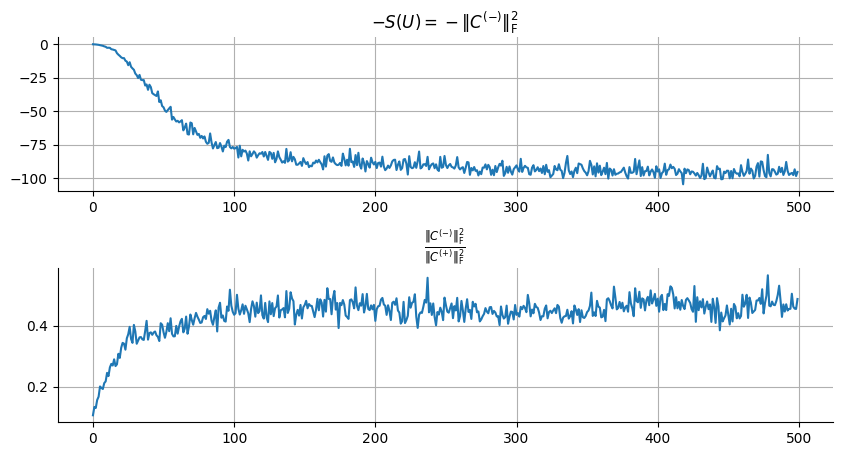

In [25]:
kernel_function=K_X_Y_rational_quadratic
c = 30
d = 2

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X_train, A, iterations=500, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )




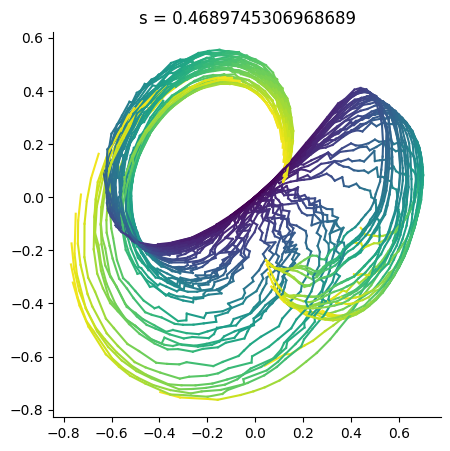

In [27]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H  = get_alpha(params, A, X_train, kernel_function, d)

K_test, _, _ = X_test.shape
X_reshaped = X_train.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_2D(Y[:,:,:])
plt.title(f's = {compute_S_all_pairs(Y)}')

np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/Y_train', Y)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_loss', np.array(ls_loss))
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_S_ratio', np.array(ls_S_ratio))

Iteration 0, S: 0.00279999990016222, S_ratio: 3.8124076695567055e-07
Iteration 10, S: 0.05480000004172325, S_ratio: 6.566119282069849e-06
Iteration 20, S: 0.09600000083446503, S_ratio: 6.990743713686243e-06
Iteration 30, S: 0.047199998050928116, S_ratio: 2.884804644054384e-06
Iteration 40, S: 0.03280000016093254, S_ratio: 2.112186166414176e-06
Iteration 50, S: 0.10480000078678131, S_ratio: 3.97830535803223e-06
Iteration 60, S: 0.17999999225139618, S_ratio: 1.0575500709819607e-05
Iteration 70, S: 0.01759999990463257, S_ratio: 6.221560511221469e-07
Iteration 80, S: 0.08799999952316284, S_ratio: 3.0804330890532583e-06
Iteration 90, S: 0.18079999089241028, S_ratio: 5.722621153836371e-06
Iteration 100, S: 0.053599998354911804, S_ratio: 2.6192078621534165e-06
Iteration 110, S: 0.12319999933242798, S_ratio: 5.796163804916432e-06
Iteration 120, S: 0.09519999474287033, S_ratio: 3.925736109522404e-06
Iteration 130, S: -0.10239999741315842, S_ratio: -3.970485067839036e-06
Iteration 140, S: 0.1136

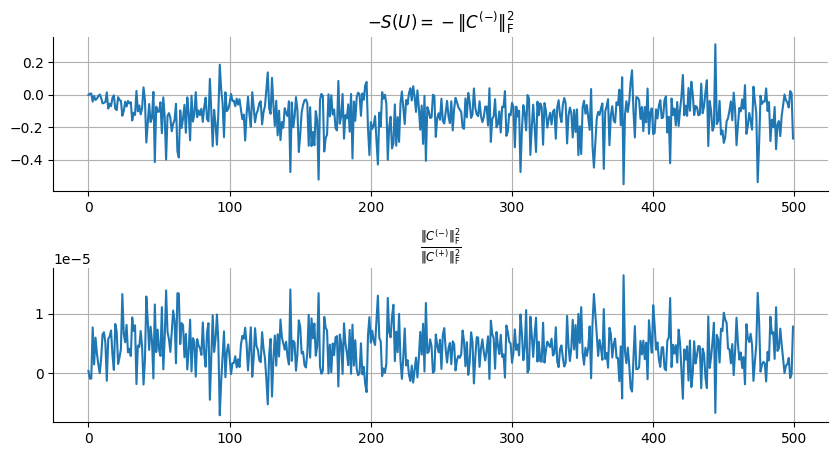

In [28]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X_train, d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )


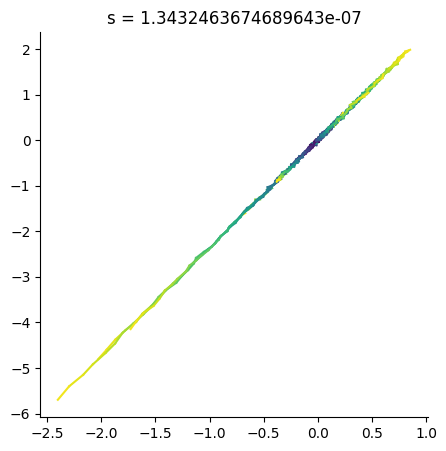

In [30]:

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X_test)
plot_2D(Y)
plt.title(f's = {compute_S_all_pairs(Y)}')

np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/Y_test', Y)
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_loss', np.array(ls_loss))
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_S_ratio', np.array(ls_S_ratio))

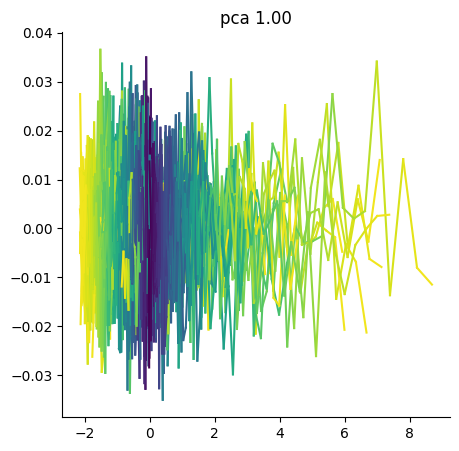

In [32]:
""" PCA """
X_pca_train = X_train.swapaxes(1,2).reshape(-1, N)
X_pca_test = X_test.swapaxes(1,2).reshape(-1, N)

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_pca_train).transform(X_pca_train)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
plt.title(f"pca {var_explained(X, PCs[:2].T):.2f}")

np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/pca/Y_train', Y_pca)

In [54]:
compute_S_all_pairs(jnp.array(Y_pca))

Array(-0.01114135, dtype=float32)